# Comparing total hydrostatic masses measured by LoCuSS and XGA

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS sample has hydrostatic mass measurements associated with them which we will compare to but the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 90
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 45/45 [02:04<00:00,  2.77s/it]
/tmp/ipykernel_81206/1394207490.py:10: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); ZwCl0949.6+5207, Abell1423, RXCJ1212.3-1816, Abell1682, Abell2485
  locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True,
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


## Reading in literature data

###  Hydrostatic masses from original work

In [4]:
loc_lit_m500s = Quantity([locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err', 'x_m500_err']].values 
                          for n in locuss_srcs.names], 'Msun')

loc_lit_m2500s = Quantity([locuss[locuss['name'] == n].iloc[0][['x_m2500', 'x_m2500_err', 'x_m2500_err']].values 
                           for n in locuss_srcs.names], 'Msun')


## Hydrostatic Mass Comparison to Literature

In [5]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [6]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [7]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [ 10., 500.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [0.1, 6. ] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0.5, 15. ] keV>, 'type': 'uniform'},
 {'prior': <Quantity [100., 500.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'}]

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to $R_{500}$, cnt$_{\rm{min}}$=3000

In [8]:
loc_sb_dblbeta_simpvikh_1_min3000_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500, 'double_beta', 
                                                                'double_king', 'simple_vikhlinin_temp', 
                                                                'r500', freeze_met=False, one_rmf=False,
                                                                temp_lo_en=Quantity(0.7, 'keV'), 
                                                                temp_hi_en=Quantity(10., 'keV'), 
                                                                temp_annulus_method='min_cnt', 
                                                                temp_min_cnt=Quantity(3000, 'ct'),
                                                                temp_use_combined=True, psf_bins=10)

Running XSPEC Fits: 100%|███████████████████████████████████████████████████████| 7/7 [01:35<00:00, 13.59s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for ZwCl0104.4+0048 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rads, cnts, ma = _cnt_bins(src, out_rad_vals[src_ind], min_cnt, min_width, lo_en, hi_en, psf_corr=psf_corr,
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for ZwCl0857.9+2107 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  rads, cnts, ma = _cnt_bins(src, out_rad_vals[src_ind], min_cnt, min_width, lo_en, hi_en, psf_corr=psf_corr,
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:508: UserWarning: The requested annuli for Abell2537 cannot be created, the data quality is too low. As such a set of four annuli will be returned


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1279.30209816 1110.56489271 1823.11298476 1614.60873259 1755.33270276
 1813.37382547]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 698.15033799  589.3142017  1236.7719754  1058.12191654 1114.67924972
 1231.48823769]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/42 [01:16<16:22, 25.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1475.24968946  746.91193312 1527.18531892 1425.08088696 1539.10123146
 1633.02617387]


Fitting data, inverse Abel transforming, and measuring densities:  10%|▊       | 4/42 [01:39<15:27, 24.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1097.87105392 1408.29704365 1921.78154695 1658.50052361 1734.79803899
 2053.78952141]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▉       | 5/42 [02:04<15:06, 24.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [307.64191287 502.86819299 124.64506381 172.31774058 271.99107635
 291.66240686]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▎      | 7/42 [02:55<14:45, 25.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [267.57648449 541.71652152 574.43653164 604.93526404 613.15348629
 513.37413895]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▌      | 8/42 [03:21<14:23, 25.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 205.56313723  225.32058371 1082.87453562 1020.19404133 1093.97994834
  952.56684088]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 11/42 [04:37<12:56, 25.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [327.25012641 482.69247724 865.33129081 226.38559156 205.66240356
 229.78059313]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 12/42 [05:06<13:03, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [938.37082911 954.15312064 994.0777965  735.58224175 842.47842618
 970.92045916]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 13/42 [05:32<12:42, 26.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1766.93810546  512.77839474 1792.69046901 1500.09092374 1638.83423813
 1763.66160364]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 14/42 [05:58<12:12, 26.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 979.96104486 1226.21325595 1395.61235837 1173.41544069 1478.83973031
 1485.56177407]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 16/42 [06:49<11:14, 25.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 684.237141    414.19768002 1728.11742107 1425.69936754 1472.32995871
 1562.00421447]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 771.14581445  769.1757327  1850.72787278 2445.10042864 2430.15682829
 1711.68002343]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 19/42 [08:08<10:08, 26.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [784.39147839 809.80763094 862.85623497 773.42080747 852.9194613
 887.75656947]


Fitting data, inverse Abel transforming, and measuring densities:  50%|███▌   | 21/42 [09:05<09:38, 27.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 741.41665061  305.06201023 1818.42793715 1708.57479981 1429.55273945
 1745.75941873]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▊   | 23/42 [09:54<08:09, 25.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1015.06531548  432.66901663 2140.77172597  718.40628877  786.51710725
 2134.38846934]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 25/42 [10:48<07:27, 26.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 883.69281131  998.37982123 1828.10344148 1558.95862332 1370.08605601
 1530.68271313]


Fitting data, inverse Abel transforming, and measuring densities:  71%|█████  | 30/42 [13:01<05:12, 26.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 840.61389191 1011.78763825 2024.45808219 1214.1072837  1149.32052014
 2039.91856825]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 32/42 [13:54<04:22, 26.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [579.75616345 567.61293207 621.51677034 731.03452279 709.55938175
 681.81977255]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 39/42 [17:05<01:19, 26.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1372.35382732  775.50656898 1526.33486433 1306.52061558 1406.46868372
 1542.70072742]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 40/42 [17:31<00:53, 26.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [378.3284196  677.45998634 524.99313843 353.65077954 475.58438708
 663.75048472]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 41/42 [17:56<00:25, 25.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1043.1536668  1000.09772192 1564.43378503 1245.88770455 1233.23562765
 1590.04402457]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 42/42 [18:20<00:00, 26.20s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 503.70249903  203.49268584 1698.82738112 1134.51400893  324.96306288
 1519.15314944]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [616.58766468 744.13294316 377.76834193 680.65532214 335.82147181
 298.17099877]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [746.82115531 767.16204411 806.62743023 554.05063428 658.44458737
 759.10544817]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/45 [00:46<34:04, 46.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [469.57090496 542.59942515 250.39885206 485.5265543  287.45573761
 242.96092505]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/45 [01:33<33:21, 46.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 468.64890851  800.18163593 1206.16088553 1180.36109197 1204.58980168
 1265.08936911]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [541.58613471 767.68877425 421.01057065 647.97397726 310.50997423
 274.89503517]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1946.6496355  1982.08465965 1843.36849809 1985.92002347 2015.14677184
 1818.30251621]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/45 [02:17<31:53, 45.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [590.04431232 507.96502278 650.77066525 429.59767451 310.43932465
 375.33800769]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/45 [03:01<30:38, 44.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1254.57710269 2064.87410314 1110.52069714 1101.38260743 1939.68783481
 1812.94403681]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/45 [03:46<30:00, 45.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [317.55099999 400.10229338 571.51501511 370.61341913 301.41987847
 312.41651986]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/45 [04:32<29:33, 45.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [385.57263659 485.38741517 601.95029374 309.70250858 296.17996887
 363.96374589]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [174.99414106 149.93906991 436.38830236 433.7731178  290.13147292
 567.41260622]


Generating Abell0267 hydrostatic mass profile:  16%|████▏                      | 7/45 [05:19<29:02, 45.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [502.41537582 508.43063289 620.83818085 437.49586509 309.53482899
 368.71750818]


Generating Abell0291 hydrostatic mass profile:  18%|████▊                      | 8/45 [06:05<28:18, 45.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [285.35017494 370.91358604 503.72320001 260.13569144 221.47801152
 242.32049724]


Generating Abell0383 hydrostatic mass profile:  20%|█████▍                     | 9/45 [06:53<27:55, 46.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [362.58586453 470.46892129 316.87962665 410.66136922 263.89416086
 245.4758721 ]


Generating Abell0521 hydrostatic mass profile:  22%|█████▊                    | 10/45 [07:43<27:44, 47.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [375.47496791 415.94827261 343.94539757 348.59523604 313.48955802
 249.05274479]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell0586 hydrostatic mass profile:  24%|██████▎                   | 11/45 [08:24<25:50, 45.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1122.94096023  988.92258051 1820.23890529 1962.10133019 2108.82469543
 1355.06629129]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [324.75291402 535.37654503 607.33633917 395.23065203 292.18788059
 260.76302677]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [407.11769084 439.8085549  463.90099852 498.55862155 497.34041522
 465.89195768]


Generating Abell0697 hydrostatic mass profile:  29%|███████▌                  | 13/45 [09:13<24:50, 46.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 991.57782696 1132.10359313  604.34391254 1107.37011968  410.84699437
  319.08728789]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1465.45587846  459.68080255  906.3580726  1725.2997847  1539.92782057
 1849.23863746]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  31%|██████▏             | 14/45 [10:00<18:29, 35.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [487.97698067 454.03287114 529.20969437 542.35495475 295.04315107
 459.1047    ]


Generating Abell0750 hydrostatic mass profile:  33%|████████▋                 | 15/45 [10:42<18:41, 37.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2170.09327553 2114.13928181  840.19640101 1475.31370256 1445.14632245
  727.57127869]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 638.86865441 1194.49556467 1257.35843974  524.37791589  315.73456134
  606.66941502]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2193.85101822 1683.2645364  2037.9984114  1988.7815403  1716.45402363
 1970.34704662]


Generating Abell0781 hydrostatic mass profile:  38%|█████████▊                | 17/45 [12:16<19:29, 41.78s/it]/tmp/ipykernel_81206/2519449106.py:1: UserWarning: The density profile for Abell0781 could not be generated
  loc_sb_dblbeta_simpvikh_1_min3000_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500, 'double_beta',
Generating Abell0901 hydrostatic mass profile:  40%|██████████▍               | 18/45 [12:16<18:48, 41.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 833.29101847  427.48356106  466.32588868 1750.88674768 1762.77012166
  784.87527448]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [456.64679759 524.58514627 444.52037416 492.72854126 282.39465019
 300.30603441]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell0907 hydrostatic mass profile:  42%|██████████▉               | 19/45 [13:02<14:36, 33.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 230.23162186  499.65892121 1041.54496527  707.16337975  496.36006587
 1333.12763618]


Generating Abell0963 hydrostatic mass profile:  44%|███████████▌              | 20/45 [13:53<15:42, 37.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [443.63471313 468.56941601 466.81559638 449.87980038 274.45498093
 646.0796761 ]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  47%|█████████▎          | 21/45 [14:39<15:58, 39.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 885.23560522 1059.36712472  496.35851331 1128.55968241  335.96346536
  840.13326425]


Generating Abell1451 hydrostatic mass profile:  49%|████████████▋             | 22/45 [15:26<16:00, 41.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [437.66803934 477.78518904 418.87719879 435.12917822 329.88930554
 325.15446267]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  51%|██████████▏         | 23/45 [16:13<15:53, 43.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [852.97780289 838.29420885 918.70770596 568.37338577 659.72152105
 894.26230085]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1779.93772836 1940.62160301 1970.74540017 1608.46816303 2025.30339789
 1967.23398938]


Generating Abell1689 hydrostatic mass profile:  53%|█████████████▊            | 24/45 [16:58<15:16, 43.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 878.4862971  1207.42002354  571.73722222 1152.71312788  329.18562841
  449.93437005]


Generating Abell1763 hydrostatic mass profile:  58%|███████████████           | 26/45 [17:46<14:11, 44.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 546.57975033  728.34840398  384.95449233  820.00567348  332.57912275
 1930.25026023]


Generating Abell1835 hydrostatic mass profile:  60%|███████████████▌          | 27/45 [18:31<10:28, 34.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2043.01519999 2144.25777819 2355.16098824 2238.07609695 2298.20585455
 2382.59483373]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 459.14123097  436.21154888  318.43422396  747.75355803  243.08669934
 1115.99990192]


Generating Abell1914 hydrostatic mass profile:  62%|████████████████▏         | 28/45 [19:22<10:57, 38.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [645.56283472 433.41820848 331.39490653 475.97942241 274.89133966
 283.62964761]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  64%|████████████▉       | 29/45 [20:09<10:55, 40.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [667.5255279  650.928348   642.34082375 529.01807743 396.57905302
 304.18304869]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▎        | 30/45 [20:56<10:38, 42.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [394.99313592 435.39512055 454.58786106 403.12948782 257.29342368
 224.30406669]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  71%|██████████████▏     | 32/45 [22:30<09:36, 44.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1352.30947351 1549.39013677 1937.65415806 1873.93411098 1824.3397503
 1937.50655361]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [731.12267063 805.94822009 541.76858316 910.09398475 385.30148114
 607.2884449 ]


Generating Abell2111 hydrostatic mass profile:  73%|███████████████████       | 33/45 [23:24<09:27, 47.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 487.98628922  579.38189754  478.68695257  637.00376802  351.83513161
 1922.73079746]


Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▋      | 34/45 [24:10<08:36, 46.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [464.22320203 601.81477924 693.34108333 546.30808686 570.48568834
 573.35817055]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▊    | 36/45 [25:06<07:25, 49.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [300.91453581 465.84812339 305.11020606 390.02637261 201.10784184
 261.35586954]


Generating Abell2261 hydrostatic mass profile:  82%|█████████████████████▍    | 37/45 [25:55<05:05, 38.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [479.00026085 714.18223652 365.34579805 576.69489192 264.24777372
 265.47247167]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 417.39443967 1061.67142253 1841.61763833 1761.71572477  680.23899727
  603.98170954]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  84%|████████████████▉   | 38/45 [26:41<04:40, 40.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [404.72383165 681.06516155 583.37272104 397.8196046  277.94271685
 298.40678594]


Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▏  | 39/45 [27:27<04:08, 41.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1852.05632468 1682.24306993 1233.32193219 2482.4308366  2479.99653875
 1676.37302893]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [415.98562231 541.35778868 332.68089171 451.75725699 266.6387709
 267.5756817 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1658.37183646 1649.23620181 1137.58033957  561.45483845 1086.0417402
  676.447807  ]


Generating Abell2390 hydrostatic mass profile:  91%|███████████████████████▋  | 41/45 [28:58<02:53, 43.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2347.58574049 2424.13615654 1978.49552049 1098.74076771  968.46746452
 1849.72770113]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 41/45 [28:58<02:53, 43.49s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 42/45 [29:44<02:11, 44.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1658.74521703 1516.48663487 1485.12098672 1452.24555275 1271.33068988
 1764.66108604]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 754.71720952 1178.79283672  317.79370719  968.82627395  388.42543014
  310.99836605]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [374.33262546 413.54164843 303.79180142 195.57523869 296.26572546
 373.79523123]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████▊ | 43/45 [30:29<01:28, 44.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [505.33287844 544.81784025 320.90124969 414.74127809 300.26735838
 239.96724533]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 44/45 [31:14<00:44, 44.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1402.42404358 1515.49632781 1754.81240288 1789.55347853 2023.71479872
 1802.35673995]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [519.05640994 572.12202569 356.38654302 479.7050369  321.52998273
 298.34824975]


Complete: 100%|███████████████████████████████████████████████████████████████| 45/45 [32:00<00:00, 42.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [539.1463677  571.24812364 701.53085649 687.83164065 680.51738089
 747.82583439]


In [9]:
loc_sb_dblbeta_simpvikh_1_mc3000_m500 = []
loc_sb_dblbeta_simpvikh_1_mc3000_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_1_min3000_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_1_min3000_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_1_mc3000_m500.append(m)
        loc_sb_dblbeta_simpvikh_1_mc3000_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_1_mc3000_m500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc3000_m500)
loc_sb_dblbeta_simpvikh_1_mc3000_m2500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc3000_m2500)

Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 45/45 [00:00<00:00, 55.43it/s]


In [10]:
print("{s} out of {t} R2500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc3000_m2500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc3000_m2500)))
print("{s} out of {t} R500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc3000_m500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc3000_m500)))

41 out of 45 R2500 mass measurements produced a result
41 out of 45 R500 mass measurements produced a result


In [11]:

np.isfinite(loc_lit_m500s[:, 0]).sum()

32

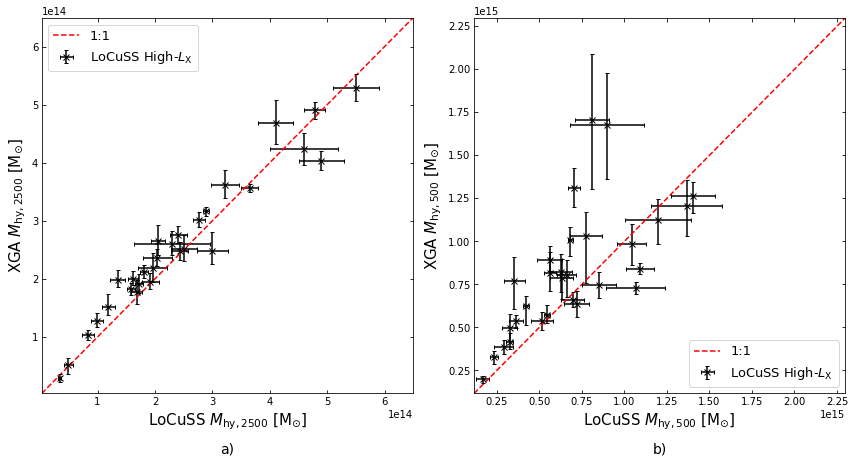

In [12]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_1_mc3000_m2500, loc_sb_dblbeta_simpvikh_1_mc3000_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'], 
                       savepath='../../outputs/figures/locuss_sb_dblbeta_simpvikh_1r500_mc3000_hymcomp.pdf')

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1115.51it/s]


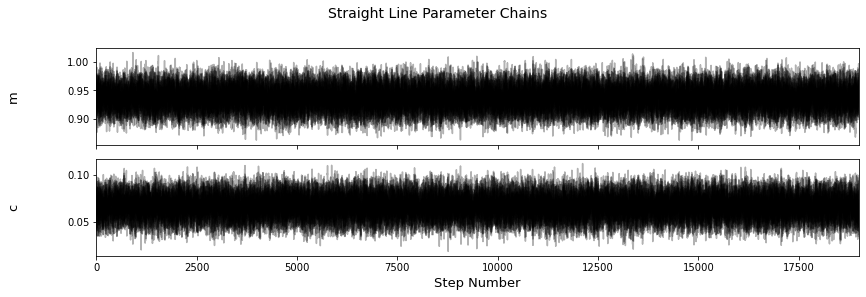

Removed no burn in


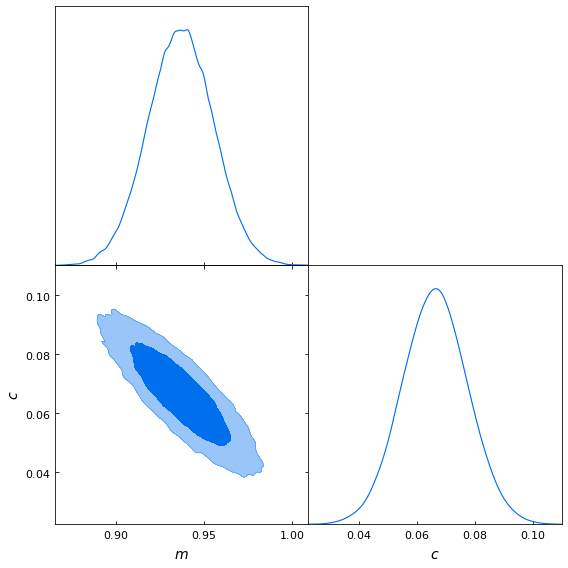

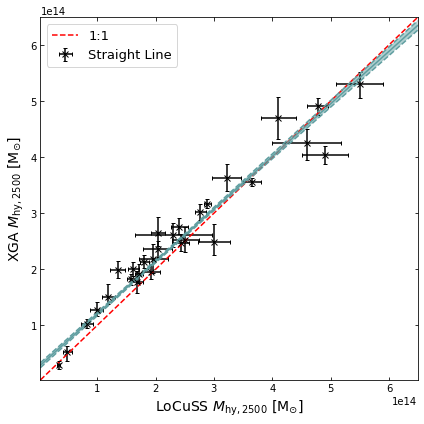

m=0.937 +0.018 -0.019 [1sig]
c=0.066 +0.011 -0.011 [1sig]


In [13]:
fit_comp(loc_lit_m2500s, loc_sb_dblbeta_simpvikh_1_mc3000_m2500, [[0, 100], [0, 5]], 
         r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", 
         r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", Quantity(4e+14, 'Msun'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)


  0%|                                                                               | 0/20000 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/emcee-3.1.1-py3.8.egg/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:18<00:00, 1107.19it/s]


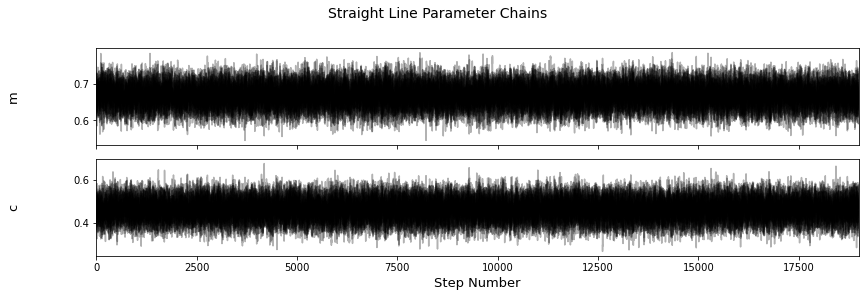

Removed no burn in


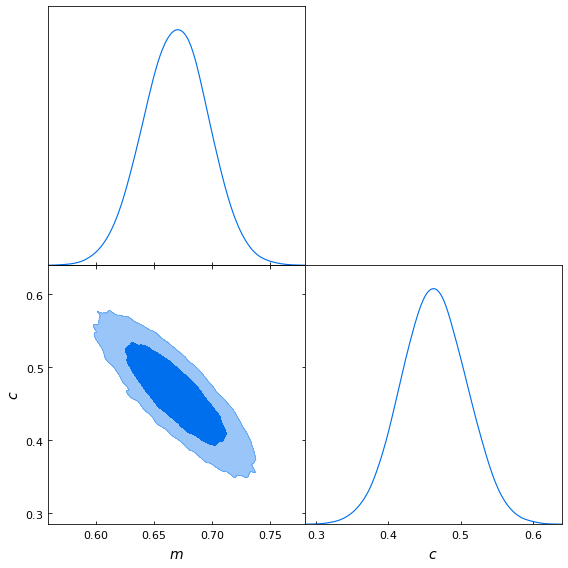

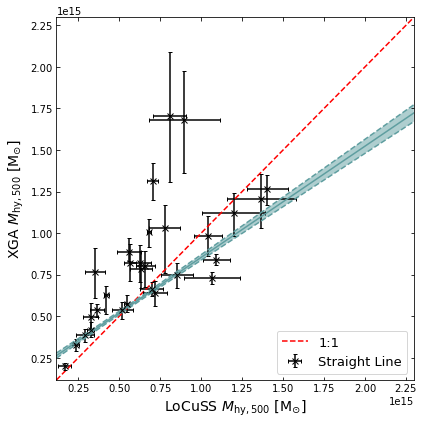

m=0.669 +0.028 -0.029 [1sig]
c=0.463 +0.046 -0.046 [1sig]


In [14]:
fit_comp(loc_lit_m500s, loc_sb_dblbeta_simpvikh_1_mc3000_m500, [[0, 100], [0, 5]], 
         r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", 
         r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]", Quantity(4e+14, 'Msun'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)


## Outputting XGA measured results as a catalogue

We wish to write the hydrostatic masses to an easily readable format which can be version controlled:

In [15]:
loc_cols = ['name', 'Mhy500', 'Mhy500-', 'Mhy500+', 'Mhy2500', 'Mhy2500-', 'Mhy2500+']
loc_data = np.hstack([locuss_srcs.names[..., None], loc_sb_dblbeta_simpvikh_1_mc3000_m500.to('1e+14 Msun').value, 
                      loc_sb_dblbeta_simpvikh_1_mc3000_m2500.to('1e+14 Msun').value])
loc_df = pd.DataFrame(loc_data, columns=loc_cols)
loc_df.to_csv('../../outputs/results/locuss_masses.csv', index=False)
loc_df.head(10)

,name,Mhy500,Mhy500-,Mhy500+,Mhy2500,Mhy2500-,Mhy2500+
0,Abell2697,8.205062589686705,1.143449001304245,1.0757656179019601,2.4747911600935666,0.15026204272585847,0.16274207206363128
1,Abell0068,9.8420197691036,1.2031287349055377,1.1706756273294552,3.623280117612646,0.2351412455106244,0.25950444098775444
2,Abell2813,7.851605385486833,1.1808258473950102,1.0986192354534214,2.3567009127131024,0.1344620465534269,0.15165740700640346
3,Abell0115S,4.14496015148221,0.37682909627132005,0.5043081085371669,0.5254382493336047,0.1563177948655979,0.1043350745908626
4,Abell141,5.122026496718743,0.3227299360874988,0.30359004509438003,0.6213503333530154,0.15174314123612878,0.15043423565338798
5,ZwCl0104.4+0048,3.3837552447554713,0.2638947850659875,0.2754675026662694,0.8077342290221804,0.04910433029937016,0.05313829346683938
6,Abell0209,5.737246551311421,0.46912747663873755,0.5404167388149038,1.9109499302182797,0.1494946016492172,0.1801274230451841
7,Abell0267,8.349489570635209,1.0710387813565538,1.12455394793067,2.1293570793014314,0.17045015869329846,0.21852587776619972
8,Abell0291,3.859407217641629,0.4027153614248676,0.3995497059753638,1.280532731508173,0.11606053665714033,0.1310059457778022
9,Abell0383,4.9787981554747525,0.7931074788155814,0.7903600387646751,2.0053481497701386,0.11768184874831251,0.13249285501652378
